Data extraction and dict construction completed in: 0.03s
loading model from:  ../../../results/riboswitch/mlp_512_riboswitch_full_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/riboswitch/mlp_512_riboswitch_full_best.ckpt


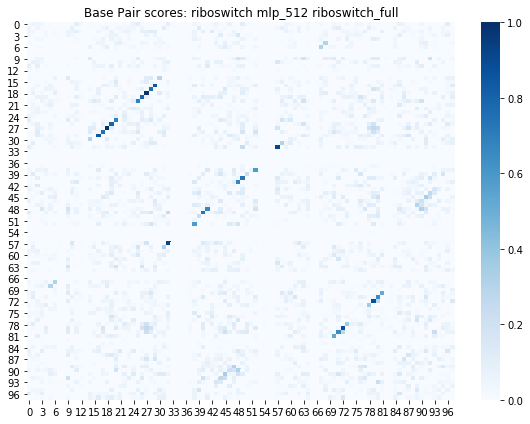

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import bpdev as bd
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

from Bio import AlignIO
import time as time
import pandas as pd
#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE ACTIONS'''
TRAIN = False
TEST = False
WRITE = False
FOM = False
SOMCALC = False
SOMVIS = True

if '--train' in sys.argv:
  TRAIN = True
if '--test' in sys.argv:
  TEST = True
if '--write' in sys.argv:
  WRITE = True
if '--fom' in sys.argv:
  FOM = True
if '--somcalc' in sys.argv:
  SOMCALC = True
if '--somvis' in sys.argv:
  SOMVIS = True

if '--mode' in sys.argv: #identifies which data/mode we are running (full, sim2k, sim2k_cut)
    modename = sys.argv[sys.argv.index('--mode')+1]
    if 'sim2k' in modename:
        modefile = 'sim2k'
    else:
        modefile = 'full'
        
modename = 'full'
modefile = 'full'

#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE LOOP'''

exp = 'riboswitch'  #for the params folder

#---------------------------------------------------------------------------------------------------------------------------------

'''OPEN DATA'''

starttime = time.time()

#Open data from h5py
filename = 'riboswitch_%s.hdf5'%(modefile)
with h5py.File(filename, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])

numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]

# get validation and test set from training set
train_frac = 0.8
valid_frac = 0.1
test_frac = 1-0.8-valid_frac
N = numdata
posidx = np.random.permutation(np.arange(N//2))
negidx = np.random.permutation(np.arange(N//2, N))

if modename == 'sim2k_cut':
    cut = 1584
else:
    cut = N
split_1 = int((cut//2)*(1-valid_frac-test_frac))
split_2 = int((cut//2)*(1-test_frac))
#shuffle = np.random.permutation(N)

trainidx = np.random.permutation(np.concatenate([posidx[:split_1], negidx[:split_1]]))
valididx = np.random.permutation(np.concatenate([posidx[split_1:split_2], negidx[split_1:split_2]]))
testidx = np.random.permutation(np.concatenate([posidx[split_2:cut//2], negidx[split_2:cut//2]]))

#set up dictionaries
train = {'inputs': X_data[trainidx],
         'targets': Y_data[trainidx]}
valid = {'inputs': X_data[valididx],
         'targets': Y_data[valididx]}
test = {'inputs': X_data[testidx],
         'targets': Y_data[testidx]}

print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

simalign_file = 'riboswitch_%s.sto'%(modefile)
#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)
#---------------------------------------------------------------------------------------------------------------------------------


'''SAVE PATHS AND PARAMETERS'''
params_results = '../../../results'

numhidden = 512
modelarch = 'mlp_%s'%(str(numhidden))
trial = 'riboswitch_%s'%(modename)
modelsavename = '%s_%s'%(modelarch, trial)

img_folder = 'Images_%s'%(modelarch)
if not os.path.isdir(img_folder):
    os.mkdir(img_folder)


'''BUILD NEURAL NETWORK'''

def cnn_model(input_shape, output_shape):


  # create model
  layer1 = {'layer': 'input', #41
          'input_shape': input_shape
          }

  layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                      # concat, embedding, variational_normal, variational_softmax, + more
            'num_units': numhidden,
            'norm': 'batch',          # if removed, automatically adds bias instead
            'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
            'dropout': 0.5,           # if removed, default is no dropout
           }

  layer3 = {'layer': 'dense',
          'num_units': output_shape[1],
          'activation': 'sigmoid'
          }

  model_layers = [layer1, layer2, layer3]

  # optimization parameters
  optimization = {"objective": "binary",
                "optimizer": "adam",
                "learning_rate": 0.0003,
                "l2": 1e-5,
                #"label_smoothing": 0.05,
                #"l1": 1e-6,
                }
  return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = os.path.join(params_results, exp)
param_path = os.path.join(save_path, modelsavename)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)



#---------------------------------------------------------------------------------------------------------------------------------

'''TRAIN '''
if TRAIN:
  # initialize session
  sess = utils.initialize_session()

  #Train the model

  data = {'train': train, 'valid': valid}
  fit.train_minibatch(sess, nntrainer, data,
                    batch_size=128,
                    num_epochs=2000,
                    patience=1000,
                    verbose=2,
                    shuffle=True,
                    save_all=False)


  sess.close()

  #---------------------------------------------------------------------------------------------------------------------------------
'''TEST'''
sess = utils.initialize_session()
if TEST:

  # set best parameters
  nntrainer.set_best_parameters(sess)

  # test model
  loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')
  if WRITE:
    metricsline = '%s,%s,%s,%s,%s,%s,%s'%(exp, modelarch, trial, loss, mean_vals[0], mean_vals[1], mean_vals[2])
    fd = open('test_metrics.csv', 'a')
    fd.write(metricsline+'\n')
    fd.close()
'''SORT ACTIVATIONS'''
nntrainer.set_best_parameters(sess)
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

#---------------------------------------------------------------------------------------------------------------------------------
'''FIRST ORDER MUTAGENESIS'''
if FOM:
  plots = 3
  num_plots = range(plots)
  fig = plt.figure(figsize=(15,plots*2+1))
  for ii in num_plots:

      X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)

      ax = fig.add_subplot(plots, 1, ii+1)
      mf.fom_saliency_mul(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, ax =ax)
      fom_file = modelsavename + 'FoM' + '.png'
  fom_file = os.path.join(img_folder, fom_file)
  plt.savefig(fom_file)

  plt.close()
#---------------------------------------------------------------------------------------------------------------------------------
'''SECOND ORDER MUTAGENESIS'''

'''Som calc'''
if SOMCALC:
  num_summary = np.min([500,len(test['inputs'])//2])

  arrayspath = 'Arrays/%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
  Xdict = test['inputs'][plot_index[:num_summary]]

  mean_mut2 = mf.som_average_ungapped(Xdict, ugidx, arrayspath, nntrainer, sess, progress='on',
                                             save=True, layer='dense_1_bias')

if SOMVIS:
  #Load the saved data
  num_summary = np.min([500,len(test['inputs'])//2])
  arrayspath = 'Arrays/%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
  denoise = 'norm'
  colour = 'Blues'
  vmin = 0.
    
  apc = False
  if apc:
      denoise = 'APC'
      colour = 'Blues'
      vmin = 0.
      modelsavename = modelsavename + 'APC'
  C = bd.get_wc(arrayspath, numug, dims, bpugSQ, denoise=denoise)

  C = C - np.mean(C)
  C = C/np.max(C)

  plt.figure(figsize=(8,6))
  sb.heatmap(C,vmin=vmin, cmap=colour, linewidth=0.0)
  plt.title('Base Pair scores: %s %s %s'%(exp, modelarch, trial))

  som_file = modelsavename + 'SoM_bpfilter' + '.png'
  som_file = os.path.join(img_folder, som_file)
  plt.show()


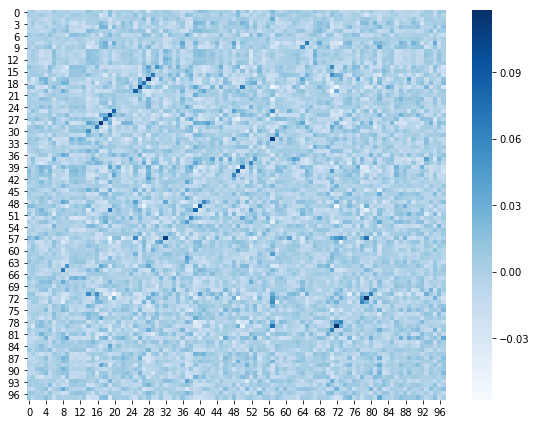

In [9]:
import bpdev as bd

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(bd.APC_hol(C), cmap='Blues', linewidth=0.0)
plt.show()

In [8]:
simugSS = ':::::(((((,,,,<-<<<<<____>>>>>><<<--<<<<<<______>>>->>>->>>,,,,,)))))-<<<<____>>>>::::::::::::::::'

In [9]:
simugSS

':::::(((((,,,,<-<<<<<____>>>>>><<<--<<<<<<______>>>->>>->>>,,,,,)))))-<<<<____>>>>::::::::::::::::'

In [12]:
X_data.shape[0]/2

792.0

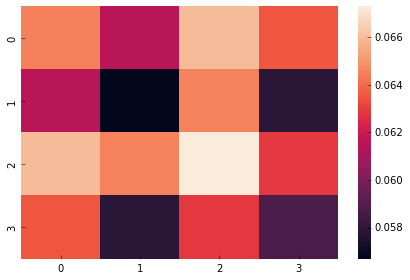

In [14]:
import bpdev as bp

s = bp.avgholbp(ugSS, numbp, dims, norm_meanhol_mut2)


In [14]:
X_data.shape

(4000, 482, 1, 4)

In [2]:
X_data.shape

(1584, 326, 1, 4)

In [15]:
len(posidx)

NameError: name 'posidx' is not defined

In [4]:
X_un[19].shape

(116, 4)

In [6]:
lengths = [len(X) for X in X_un]
print (np.min(lengths), np.mean(lengths), np.max(lengths))

89 103.6540404040404 159


/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


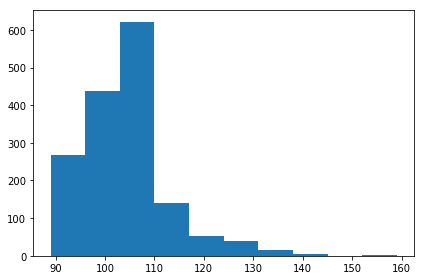

In [7]:
plt.hist(lengths)
plt.show()

75 101.78525 144


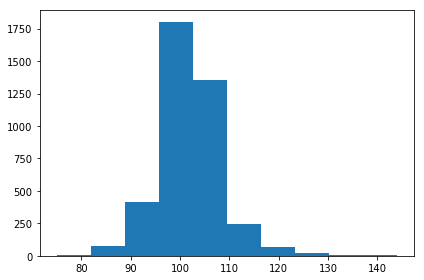

In [9]:
X_un = mf.unalign_full(X_data)
lengths = [len(X) for X in X_un]
print (np.min(lengths), np.mean(lengths), np.max(lengths))
plt.hist(lengths)
plt.show()

In [27]:
numdata

4000

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

from Bio import AlignIO
import time as time
import pandas as pd
#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE ACTIONS'''
TRAIN = False
TEST = True
WRITE = False
FOM = False
SOMCALC = False
SOMVIS = False

if '--train' in sys.argv:
  TRAIN = True
if '--test' in sys.argv:
  TEST = True
if '--write' in sys.argv:
  WRITE = True
if '--fom' in sys.argv:
  FOM = True
if '--somcalc' in sys.argv:
  SOMCALC = True
if '--somvis' in sys.argv:
  SOMVIS = True

#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE LOOP'''

exp = 'riboswitch'  #for the params folder

#---------------------------------------------------------------------------------------------------------------------------------

'''OPEN DATA'''

starttime = time.time()

#Open data from h5py
filename = 'riboswitch_sim2k.hdf5'
with h5py.File(filename, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])

numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]

# get validation and test set from training set
train_frac = 0.8
valid_frac = 0.1
test_frac = 1-0.8-valid_frac
N = numdata
posidx = np.random.permutation(np.arange(N//2))
negidx = np.random.permutation(np.arange(N//2, N))

cut = N#1584
split_1 = int((cut//2)*(1-valid_frac-test_frac))
split_2 = int((cut//2)*(1-test_frac))
#shuffle = np.random.permutation(N)

trainidx = np.random.permutation(np.concatenate([posidx[:split_1], negidx[:split_1]]))
valididx = np.random.permutation(np.concatenate([posidx[split_1:split_2], negidx[split_1:split_2]]))
testidx = np.random.permutation(np.concatenate([posidx[split_2:cut//2], negidx[split_2:cut//2]]))

#set up dictionaries
train = {'inputs': X_data[trainidx],
         'targets': Y_data[trainidx]}
valid = {'inputs': X_data[valididx],
         'targets': Y_data[valididx]}
test = {'inputs': X_data[testidx],
         'targets': Y_data[testidx]}

print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

simalign_file = 'riboswitch_sim2k.sto'
#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)
#---------------------------------------------------------------------------------------------------------------------------------


'''SAVE PATHS AND PARAMETERS'''
params_results = '../../../results'

numhidden = 88#int(sys.argv[1])
modelarch = 'mlp_%s'%(str(numhidden))
trial = 'sim2k'#_cut'
modelsavename = '%s_%s'%(modelarch, trial)

img_folder = 'Images_%s'%(modelarch)
if not os.path.isdir(img_folder):
    os.mkdir(img_folder)


'''BUILD NEURAL NETWORK'''

def cnn_model(input_shape, output_shape):


  # create model
  layer1 = {'layer': 'input', #41
          'input_shape': input_shape
          }

  layer2 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                      # concat, embedding, variational_normal, variational_softmax, + more
            'num_units': numhidden,
            'norm': 'batch',          # if removed, automatically adds bias instead
            'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
            'dropout': 0.5,           # if removed, default is no dropout
           }

  layer3 = {'layer': 'dense',
          'num_units': output_shape[1],
          'activation': 'sigmoid'
          }

  model_layers = [layer1, layer2, layer3]

  # optimization parameters
  optimization = {"objective": "binary",
                "optimizer": "adam",
                "learning_rate": 0.0003,
                "l2": 1e-5,
                #"label_smoothing": 0.05,
                #"l1": 1e-6,
                }
  return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = os.path.join(params_results, exp)
param_path = os.path.join(save_path, modelsavename)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)



#---------------------------------------------------------------------------------------------------------------------------------

'''TRAIN '''
if TRAIN:
  # initialize session
  sess = utils.initialize_session()

  #Train the model

  data = {'train': train, 'valid': valid}
  fit.train_minibatch(sess, nntrainer, data,
                    batch_size=128,
                    num_epochs=2000,
                    patience=2000,
                    verbose=2,
                    shuffle=True,
                    save_all=False)


  sess.close()

  #---------------------------------------------------------------------------------------------------------------------------------
'''TEST'''
sess = utils.initialize_session()
if TEST:

  # set best parameters
  nntrainer.set_best_parameters(sess)

  # test model
  loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')
  if WRITE:
    metricsline = '%s,%s,%s,%s,%s,%s,%s'%(exp, modelarch, trial, loss, mean_vals[0], mean_vals[1], mean_vals[2])
    fd = open('test_metrics.csv', 'a')
    fd.write(metricsline+'\n')
    fd.close()
'''SORT ACTIVATIONS'''
nntrainer.set_best_parameters(sess)
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

#---------------------------------------------------------------------------------------------------------------------------------
'''FIRST ORDER MUTAGENESIS'''
if FOM:
  plots = 3
  num_plots = range(plots)
  fig = plt.figure(figsize=(15,plots*2+1))
  for ii in num_plots:

      X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)

      ax = fig.add_subplot(plots, 1, ii+1)
      mf.fom_saliency_mul(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, ax =ax)
      fom_file = modelsavename + 'FoM' + '.png'
  fom_file = os.path.join(img_folder, fom_file)
  plt.savefig(fom_file)

  plt.close()
#---------------------------------------------------------------------------------------------------------------------------------
'''SECOND ORDER MUTAGENESIS'''

'''Som calc'''
if SOMCALC:
  num_summary = np.min([500,len(test['inputs'])//2])

  arrayspath = 'Arrays/%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
  Xdict = test['inputs'][plot_index[:num_summary]]

  mean_mut2 = mf.som_average_ungapped(Xdict, ugidx, arrayspath, nntrainer, sess, progress='on',
                                             save=True, layer='dense_1_bias')

if SOMVIS:
  #Load the saved data
  num_summary = np.min([500,len(test['inputs'])//2])
  arrayspath = 'Arrays/%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
  mean_mut2 = np.load(arrayspath)

  #Reshape into a holistic tensor organizing the mutations into 4*4
  meanhol_mut2 = mean_mut2.reshape(numug,numug,4,4)

  #Normalize
  normalize = True
  if normalize:
      norm_meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer, sess, normfactor=1)

  #Let's try something weird
  bpfilter = np.ones((4,4))*0.
  for i,j in zip(range(4), range(4)):
      bpfilter[i, -(j+1)] = +1.

  nofilter = np.ones((4,4))

  C = (norm_meanhol_mut2*bpfilter)
  C = np.sum((C).reshape(numug,numug,dims*dims), axis=2)
  C = C - np.mean(C)
  C = C/np.max(C)

  plt.figure(figsize=(8,6))
  sb.heatmap(C,vmin=None, cmap='Blues', linewidth=0.0)
  plt.title('Base Pair scores: %s %s %s'%(exp, modelarch, trial))

  som_file = modelsavename + 'SoM_bpfilter' + '.png'
  som_file = os.path.join(img_folder, som_file)
  plt.savefig(som_file)
  plt.show()
  plt.close()


Data extraction and dict construction completed in: 0.11s
loading model from:  ../../../results/riboswitch/mlp_88_sim2k_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/riboswitch/mlp_88_sim2k_best.ckpt


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../../../results/riboswitch/mlp_88_sim2k_best.ckpt
	 [[Node: save/RestoreV2_13 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_13/tensor_names, save/RestoreV2_13/shape_and_slices)]]
	 [[Node: save/RestoreV2_15/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_42_save/RestoreV2_15", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'save/RestoreV2_13', defined at:
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-833f977da5ce>", line 214, in <module>
    nntrainer.set_best_parameters(sess)
  File "../../../../deepomics/neuralnetwork.py", line 522, in set_best_parameters
    self.nnmodel.load_model_parameters(sess, file_path, verbose=verbose)
  File "../../../../deepomics/neuralnetwork.py", line 173, in load_model_parameters
    saver = tf.train.Saver()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ../../../results/riboswitch/mlp_88_sim2k_best.ckpt
	 [[Node: save/RestoreV2_13 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_13/tensor_names, save/RestoreV2_13/shape_and_slices)]]
	 [[Node: save/RestoreV2_15/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_42_save/RestoreV2_15", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [22]:
train['targets'].shape

(1266, 1)

In [23]:
X_data.shape

(4000, 482, 1, 4)

In [26]:
train['targets'].sum()

633.0